# Model Training & Evaluation
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import spearmanr
import gspread
from sklearn.impute import KNNImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
from google.auth import default

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data found from US Census Bureau for wealth inequality
# drop na to remove irrelevant rows (footnotes)
wealth = pd.read_excel('/content/drive/My Drive/DAT 490 Capstone Project/Project Data/Census Bureau Wealth Inequality/Census Bureau Income Dist 1967-2023.xlsx'
                        , header = 5).rename(columns = {'Unnamed: 0':'year'}).dropna()

# replace newline char with space in column names
wealth.columns = wealth.columns.str.replace('\s', ' ', regex = True)

# clean year column
wealth['year'] = wealth['year'].replace('\s',' ', regex = True).replace('\s.*','', regex = True)

In [ ]:
geowealth = pd.read_csv('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/GEOWEALTH-US/state_wealth_inequality.csv')
navco_us = pd.read_excel('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/NAVCO 3.0 Dataset/NAVCO3.0_US.xlsx')
inflation = pd.read_csv('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/Annual-inflation/inflation-gdp.csv')
ccc_1 = pd.read_csv('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/Crowd Counting Consortium Dataset/ccc_compiled_2017-2020.csv', encoding='latin-1'); # encoding changed to 'latin-1' to avoid an error
ccc_2 = pd.read_csv('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/Crowd Counting Consortium Dataset/ccc_compiled_2021-present.csv', encoding='latin-1');

ccc = pd.concat([ccc_1, ccc_2]) # Append ccc_2 to ccc_1 to create full ccc dataset

<ipython-input-4-bd5c11c790e0>:4: DtypeWarning: Columns (7,10,24,26,37,38,39,40,41,42,43,44,45,46,47,48,49,53,59) have mixed types. Specify dtype option on import or set low_memory=False.
  ccc_1 = pd.read_csv('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/Crowd Counting Consortium Dataset/ccc_compiled_2017-2020.csv', encoding='latin-1'); # encoding changed to 'latin-1' to avoid an error
<ipython-input-4-bd5c11c790e0>:5: DtypeWarning: Columns (22,24,31,32,51,52,53,54,55,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  ccc_2 = pd.read_csv('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/Crowd Counting Consortium Dataset/ccc_compiled_2021-present.csv', encoding='latin-1');


### EDA (run first)

In [ ]:
inflation[inflation['Country'] == 'United States']

,Country,Country Code,Year,Inflation
10559,United States,USA,1961,1.350154
10560,United States,USA,1962,1.244635
10561,United States,USA,1963,1.088386
10562,United States,USA,1964,1.503940
10563,United States,USA,1965,1.919826
10564,United States,USA,1966,2.898779
10565,United States,USA,1967,3.151279
10566,United States,USA,1968,4.367188
10567,United States,USA,1969,4.958488
10568,United States,USA,1970,2.211442


In [ ]:
# Consumer Price Index Data from Bureau of Labor Statistics

auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)
worksheet = gc.open('BLS CPI 1999-2024').sheet1
rows = worksheet.get_all_values()

CPI = pd.DataFrame.from_records(rows)
CPI = pd.DataFrame(data = CPI.values[1:], columns = CPI.iloc[0])

CPI

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1999,164.3,164.5,165,166.2,166.2,166.2,166.7,167.1,167.9,168.2,168.3,168.3,166.6,165.4,167.8
1,2000,168.8,169.8,171.2,171.3,171.5,172.4,172.8,172.8,173.7,174,174.1,174,172.2,170.8,173.6
2,2001,175.1,175.8,176.2,176.9,177.7,178,177.5,177.5,178.3,177.7,177.4,176.7,177.1,176.6,177.5
3,2002,177.1,177.8,178.8,179.8,179.8,179.9,180.1,180.7,181,181.3,181.3,180.9,179.9,178.9,180.9
4,2003,181.7,183.1,184.2,183.8,183.5,183.7,183.9,184.6,185.2,185,184.5,184.3,184,183.3,184.6
5,2004,185.2,186.2,187.4,188,189.1,189.7,189.4,189.5,189.9,190.9,191,190.3,188.9,187.6,190.2
6,2005,190.7,191.8,193.3,194.6,194.4,194.5,195.4,196.4,198.8,199.2,197.6,196.8,195.3,193.2,197.4
7,2006,198.3,198.7,199.8,201.5,202.5,202.9,203.5,203.9,202.9,201.8,201.5,201.8,201.6,200.6,202.6
8,2007,202.416,203.499,205.352,206.686,207.949,208.352,208.299,207.917,208.49,208.936,210.177,210.036,207.342,205.709,208.976
9,2008,211.08,211.693,213.528,214.823,216.632,218.815,219.964,219.086,218.783,216.573,212.425,210.228,215.303,214.429,216.177


In [ ]:
# US unemployment rate from the Bureau of Labor Statistics

unemprate = pd.read_excel('/content/drive/My Drive/DAT 490 Capstone Project/Data For Final Results/BLS CPI/BLS-Unemp-Rate-1999-2024.xlsx', header=11)

unemprate

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1999,4.3,4.4,4.2,4.3,4.2,4.3,4.3,4.2,4.2,4.1,4.1,4.0
1,2000,4.0,4.1,4.0,3.8,4.0,4.0,4.0,4.1,3.9,3.9,3.9,3.9
2,2001,4.2,4.2,4.3,4.4,4.3,4.5,4.6,4.9,5.0,5.3,5.5,5.7
3,2002,5.7,5.7,5.7,5.9,5.8,5.8,5.8,5.7,5.7,5.7,5.9,6.0
4,2003,5.8,5.9,5.9,6.0,6.1,6.3,6.2,6.1,6.1,6.0,5.8,5.7
5,2004,5.7,5.6,5.8,5.6,5.6,5.6,5.5,5.4,5.4,5.5,5.4,5.4
6,2005,5.3,5.4,5.2,5.2,5.1,5.0,5.0,4.9,5.0,5.0,5.0,4.9
7,2006,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
8,2007,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5.0
9,2008,5.0,4.9,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3


In [ ]:
# Create method to convert 3-letter month to number

def process_monthly_data(df, value_name='unemprate', year_start=1999):
    df_month = df.melt(
        id_vars='Year',
        value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        var_name='month',
        value_name=value_name
    ).rename(columns={'Year': 'year'})

    df_month['month'] = df_month['month'].astype(
        pd.CategoricalDtype(categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
    )

    months_dict = {month: i+1 for i, month in enumerate(df_month['month'].unique())}
    df_month['month'] = df_month['month'].map(months_dict).astype(int)
    df_month[value_name] = df_month[value_name].replace('', '0.0').astype(float).replace(0.0, np.nan)
    df_month['year'] = df_month['year'].astype(int)
    df_month['Monthly % Change'] = round(df_month[value_name].replace(np.nan, 0.0).pct_change() * 100, 4)
    df_month = df_month[df_month['year'] >= year_start].dropna().sort_values(by=['year', 'month']).reset_index(drop=True)

    return df_month

In [ ]:
# create dataframe for monthly inflation data

CPI_month = process_monthly_data(CPI, value_name='CPI', year_start=1999)

CPI_month

,year,month,CPI,Monthly % Change
0,1999,2,164.500,-46.6631
1,1999,3,165.000,-46.8301
2,1999,4,166.200,-46.7874
3,1999,5,166.200,-46.9938
4,1999,6,166.200,-47.0817
...,...,...,...,...
302,2024,4,313.548,3.3574
303,2024,5,314.069,3.2690
304,2024,6,314.175,2.9714
305,2024,7,314.540,2.8948


In [ ]:
# create dataframe for monthly unemployment rate data
unemprate_month = process_monthly_data(unemprate, value_name='unemprate', year_start=1999)

unemprate_month

,year,month,unemprate,Monthly % Change
0,1999,2,4.4,18.9189
1,1999,3,4.2,7.6923
2,1999,4,4.3,13.1579
3,1999,5,4.2,7.6923
4,1999,6,4.3,7.5000
...,...,...,...,...
303,2024,5,4.0,8.1081
304,2024,6,4.1,13.8889
305,2024,7,4.3,22.8571
306,2024,8,4.2,10.5263


In [ ]:
# create dataframe for annual inflation data
CPI_year = CPI[['Year', 'Annual']].rename(columns = {'Year':'year','Annual':'CPI'})

# convert dtypes
CPI_year = CPI_year.replace('','0.0').astype({'year':'int', 'CPI':'float'}).replace(0.0,np.nan)

# add annual inflation for 2024
CPI_year.iloc[-1:] = [2024, np.mean(CPI_month['CPI'].loc[CPI_month['year'] == 2024])]

# # calculate % annual change in CPI
CPI_year['annual % Change'] = round(CPI_year['CPI'].pct_change() * 100, 4)

# drop null values
CPI_year = CPI_year.dropna()

CPI_year

,year,CPI,annual % Change
1,2000,172.200000,3.3613
2,2001,177.100000,2.8455
3,2002,179.900000,1.5810
4,2003,184.000000,2.2790
5,2004,188.900000,2.6630
6,2005,195.300000,3.3880
7,2006,201.600000,3.2258
8,2007,207.342000,2.8482
9,2008,215.303000,3.8396
10,2009,214.537000,-0.3558


In [ ]:
# create data frame for yearly unemployment data
unemprate_year = unemprate_month.groupby('year')['unemprate'].mean().reset_index()

unemprate_year['annual % Change'] = round(unemprate_year['unemprate'].pct_change() * 100, 4)

unemprate_year = unemprate_year.dropna()

unemprate_year

,year,unemprate,annual % Change
1,2000,3.966667,-5.7595
2,2001,4.741667,19.5378
3,2002,5.783333,21.9684
4,2003,5.991667,3.6023
5,2004,5.541667,-7.5104
6,2005,5.083333,-8.2707
7,2006,4.608333,-9.3443
8,2007,4.616667,0.1808
9,2008,5.800000,25.6318
10,2009,9.283333,60.0575


In [ ]:
# adding year and month columns to ccc data
ccc['year'] = ccc['date'].str[:4]
ccc['month'] = ccc['date'].str[5:7]
ccc[['year', 'month']] = ccc[['year', 'month']].astype(np.int64)

# Extract the year and create a new 'year' column
navco_us['year'] = navco_us['date'].astype(str).str[:4]

print(ccc[['date', 'year']].head())
print(navco_us[['date', 'year']].head())

         date  year
0  2017-01-01  2017
1  2017-01-01  2017
2  2017-01-01  2017
3  2017-01-01  2017
4  2017-01-01  2017
        date  year
0 2007-01-21  2007
1 2007-01-23  2007
2 2007-03-08  2007
3 2007-03-19  2007
4 2007-04-15  2007


In [ ]:
navco_us['month'] = navco_us['date'].dt.month.astype(int)

In [ ]:
pd.set_option('display.max_columns', None)
print(geowealth.shape)
geowealth.head()

(350, 39)


,year,state,obs,households,wealth_mean,wealth_median,wealth_top1,wealth_top.1,wealth_top.01,wealth_top.001,wealth_top10,wealth_bottom50,wealth_gini,wealth_sd,p90,p10,income_mean,house_value_mean,own,rent,own_outright,own_mortgage,college,white,black,hispanic,female,household_size,age,mean_sd,top1_sd,top.1_sd,top.01_sd,top.001_sd,top10_sd,bottom50_sd,top5_sd,top.5_sd,gini_sd
0,1960,alabama,42847,856940.0,77278.162,35100.750,0.211,0.085,0.034,0.014,0.540,0.062,0.726,234662.739,166974.436,-2126.812,40382.539,48518.843,0.589,0.411,NaN,NaN,0.139,0.738,0.261,0.000,0.177,3.678,47.131,448.374,0.005,0.004,0.002,0.001,0.003,0.000,0.003,0.005,0.017
1,1960,alaska,2750,55000.0,97790.092,36482.414,0.170,0.062,0.026,0.012,0.527,0.244,0.697,187199.257,236162.528,3572.022,66925.968,47580.207,0.456,0.544,NaN,NaN,0.258,0.830,0.030,0.001,0.086,3.480,40.230,4025.317,0.032,0.019,0.008,0.003,0.019,0.378,0.025,0.030,0.028
2,1960,arizona,17694,353880.0,108872.732,45300.973,0.218,0.087,0.036,0.014,0.558,0.069,0.729,280238.536,236346.705,0.000,54434.901,64127.141,0.625,0.375,NaN,NaN,0.247,0.920,0.034,0.003,0.151,3.463,45.635,1082.775,0.007,0.004,0.001,0.001,0.004,0.001,0.006,0.006,0.021
3,1960,arkansas,25150,503000.0,73961.529,35263.136,0.161,0.059,0.023,0.009,0.507,0.072,0.689,147355.794,176916.020,-1981.737,32873.483,41309.995,0.602,0.398,NaN,NaN,0.132,0.812,0.187,0.000,0.168,3.412,49.749,1649.743,0.018,0.012,0.007,0.002,0.011,0.002,0.014,0.018,0.019
4,1960,california,237916,4758320.0,141314.694,60621.910,0.224,0.088,0.036,0.014,0.559,0.058,0.743,387565.887,293638.340,-2229.737,63436.406,85868.095,0.565,0.435,NaN,NaN,0.281,0.931,0.049,0.001,0.184,3.079,46.396,1547.357,0.009,0.006,0.003,0.001,0.005,0.001,0.006,0.009,0.020


In [ ]:
# Count NaN values in each column
print(geowealth.isna().sum())

year                 0
state                0
obs                  0
households           0
wealth_mean          0
wealth_median        0
wealth_top1          0
wealth_top.1         0
wealth_top.01        0
wealth_top.001       0
wealth_top10         0
wealth_bottom50      0
wealth_gini          0
wealth_sd            0
p90                  0
p10                  0
income_mean          0
house_value_mean     0
own                  0
rent                 0
own_outright        95
own_mortgage        95
college              0
white                0
black                0
hispanic             0
female               0
household_size       0
age                  0
mean_sd              0
top1_sd              0
top.1_sd             0
top.01_sd            0
top.001_sd           0
top10_sd             0
bottom50_sd          0
top5_sd              0
top.5_sd             0
gini_sd              0
dtype: int64


In [ ]:
for i in geowealth['year'].unique():
  print(f'There are {geowealth.loc[geowealth["year"] == i].isna().sum().sum()} null values for the Year {i}.')

There are 0 null values for the Year 1960.
There are 0 null values for the Year 1970.
There are 0 null values for the Year 1980.
There are 0 null values for the Year 1990.
There are 0 null values for the Year 2000.
There are 0 null values for the Year 2010.
There are 0 null values for the Year 2020.


In [ ]:
# Since only roughly 27% of the values in the columns 'own_outright' and 'own_mortgage' contain null values, I will be
# using a KNNImputer to fill the missing values based on nearest neighbors.

imputer = KNNImputer(n_neighbors=5)
geowealth[['own_outright', 'own_mortgage']] = imputer.fit_transform(geowealth[['own_outright', 'own_mortgage']])

# Count NaN values in each column again
print(geowealth.isna().sum())

year                0
state               0
obs                 0
households          0
wealth_mean         0
wealth_median       0
wealth_top1         0
wealth_top.1        0
wealth_top.01       0
wealth_top.001      0
wealth_top10        0
wealth_bottom50     0
wealth_gini         0
wealth_sd           0
p90                 0
p10                 0
income_mean         0
house_value_mean    0
own                 0
rent                0
own_outright        0
own_mortgage        0
college             0
white               0
black               0
hispanic            0
female              0
household_size      0
age                 0
mean_sd             0
top1_sd             0
top.1_sd            0
top.01_sd           0
top.001_sd          0
top10_sd            0
bottom50_sd         0
top5_sd             0
top.5_sd            0
gini_sd             0
dtype: int64


In [ ]:
print(navco_us.shape)
navco_us.head()

(1775, 39)


,coder,event_desc,country_name,cowcode,date,source_title,geo_scope,localities,actor_id,cameo_actor_3,cameo_actor_6,cameo_actor_9,event_actor_list,verb_10,verb_100,verb_1000,target_3,target_6,target_9,camp_goals,tactical_choice,nv_categ,nc_type,nv_commission,nv_concentration,nv_tactic_ns,v_tactic_ns,st_posture,fatal_casu,injuries,num_partic_event,damage,econ_impact,econ_impact_aux,arbitration,notes,decision,year,month
0,AS,scholar at New America Foundation states Bush ...,United States,2,2007-01-21,US aims to trump skeptics with Mideast push,2,Washington,4,NON,ELI,IND,"Anatol Lieven, a scholar at the New America Fo...",11,111,NaN,GOV,TOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,actor_code changed to NON ELI IND,2007,1
1,AS,US implements Western Hemisphere Travel Initia...,United States,2,2007-01-23,Americans and their neighbors must fly with pa...,3,Washington,1,GOV,NaN,NaN,US Government,17,172,NaN,REB,MOS,HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,verb code?,"verb code appears appropriate, kept as is",2007,1
2,AS,China publishes accusatory human rights report,United States,2,2007-03-08,China takes US to task in human rights retort,4,Beijing,3,CHN,GOV,NaN,the State Council,11,112,1122.0,GOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,report titled: The Human Rights Record of the ...,"coding appears appropriate, kept as is",2007,3
3,AS,Democrats in the Senate denounce Bush's war in...,United States,2,2007-03-19,Bush warns against US pullout in Iraq on war's...,2,Washington,2,OPP,LEG,TOP,Senate Majority Leader Harry Reid,11,111,NaN,GOV,TOP,NaN,2.0,1.0,0.0,NaN,NaN,NaN,statement denouncing conduct of the war,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,states the war has been a series of blunders,verb coded as 111,2007,3
4,AS,security forces on strike in Texas,United States,2,2007-04-15,Strike at US nuclear weapons site raises secur...,1,"Amarillo, TX",2,ACT,LAB,NaN,Pantex Guards Union,14,141,NaN,GOV,BUS,TOP,2.0,1.0,2.0,3.0,0.0,0.0,conducted a six week strike for retirement ben...,NaN,NaN,NaN,NaN,500,NaN,NaN,NaN,1,not really a political issue but has the Dept....,based on review of source does appear to be po...,2007,4


In [ ]:
# Count NaN values in each column
print(navco_us.isna().sum())

coder                 0
event_desc            0
country_name          0
cowcode               0
date                  0
source_title          0
geo_scope             0
localities            0
actor_id              0
cameo_actor_3         0
cameo_actor_6       354
event_actor_list      0
verb_10               0
verb_100              0
target_3              0
target_6            679
arbitration           0
year                  0
month                 0
dtype: int64


In [ ]:
# To start I will plan on dropping any columns containing 50% or more NaN values
threshold = len(navco_us) * 0.5

# Drop columns with 50% or more NaN values
navco_us = navco_us.dropna(thresh=threshold, axis=1)

# Count NaN values in each column again
print(navco_us.isna().sum())

coder                 0
event_desc            0
country_name          0
cowcode               0
date                  0
source_title          0
geo_scope             0
localities            0
actor_id              0
cameo_actor_3         0
cameo_actor_6       354
event_actor_list      0
verb_10               0
verb_100              0
target_3              0
target_6            679
arbitration           0
year                  0
month                 0
dtype: int64


In [ ]:
print(CPI_year.shape)
CPI_year.head()

(25, 3)


,year,CPI,annual % Change
1,2000,172.2,3.3613
2,2001,177.1,2.8455
3,2002,179.9,1.5810
4,2003,184.0,2.2790
5,2004,188.9,2.6630


In [ ]:
# Count NaN values in each column
print(CPI_year.isna().sum())

0
year               0
CPI                0
annual % Change    0
dtype: int64


In [ ]:
print(ccc.shape)
ccc.head()

(200853, 72)


,date,locality,state,location_detail,online,type,title,macroevent,actors,organizations,participants,claims,valence,issues,issues_major,size_text,size_low,size_high,size_mean,size_cat,arrests,arrests_any,injuries_crowd,injuries_crowd_any,injuries_police,injuries_police_any,property_damage,property_damage_any,chemical_agents,participant_measures,police_measures,participant_deaths,police_deaths,source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,source_10,source_11,source_12,source_13,source_14,source_15,source_16,source_17,source_18,source_19,source_20,source_21,source_22,source_23,source_24,source_25,source_26,source_27,source_28,source_29,source_30,notes,lat,lon,resolved_locality,resolved_county,resolved_state,fips_code,year,month
0,2017-01-01,Washington,DC,Lafayette Square Park,0.0,vigil,White House Peace Vigil,NaN,NaN,NaN,NaN,"for banning nuclear weapons, for peace",0.0,military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/White_House_Peac...,https://www.youtube.com/watch?v=uy5PQNRNk2s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White House Peace Vigil continuous since June ...,38.907192,-77.036871,Washington,District of Columbia,DC,11001.0,2017,1
1,2017-01-01,Mankato,MN,NaN,0.0,vigil,NaN,NaN,Peace Vigil Mankato,Peace Vigil Mankato,NaN,for peace,0.0,military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,https://www.mankatofreepress.com/news/local_ne...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,every Sunday since 2001,44.163578,-93.999400,Mankato,Blue Earth County,MN,27013.0,2017,1
2,2017-01-01,Minneapolis,MN,U.S. Bank Stadium,0.0,protest; banner drop,NaN,NaN,general protestors,NaN,NaN,"against the Dakota Access Pipeline, for indige...",1.0,banking and finance; economy; energy; environm...,NaN,2,2.0,2.0,2.0,1,2,1,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,https://www.reuters.com/article/us-northdakota...,https://www.nbcnews.com/storyline/dakota-pipel...,https://www.twincities.com/2017/01/01/protest-...,https://bleacherreport.com/articles/2684655-pr...,https://www.startribune.com/pipeline-protestor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hung banner from stadium roof during NFL game,44.977753,-93.265011,Minneapolis,Hennepin County,MN,27053.0,2017,1
3,2017-01-01,Little Compton,RI,Town Green,0.0,vigil,NaN,NaN,Sakonnet Peace Alliance,Sakonnet Peace Alliance,NaN,"for peace, for gun control, for climate action",1.0,environment; guns; military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,https://ecori.org/hardy-little-compton-allianc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,every Sunday since 2003,41.510103,-71.171156,Little Compton,Newport County,RI,44005.0,2017,1
4,2017-01-01,Oak Ridge,TN,Y-12 National Security Complex,0.0,vigil,NaN,NaN,Oak Ridge Environmental Peace Alliance,Oak Ridge Environmental Peace Alliance,NaN,for abolishing nuclear weapons,0.0,military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,https://www.orepa.org/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,every Sunday since the late 1990s,36.010356,-84.269645,Oak Ridge,Anderson County,TN,47001.0,2017,1


In [ ]:
# Beginning cleaning up missing values. Upon checking the data dictionary for this dataset, all of the columns labeled 'source_n' are safe to drop.
columns_to_drop = ccc.filter(like='source_').columns
ccc = ccc.drop(columns=columns_to_drop)

# Checking the results
ccc.head()

,date,locality,state,location_detail,online,type,title,macroevent,actors,organizations,participants,claims,valence,issues,issues_major,size_text,size_low,size_high,size_mean,size_cat,arrests,arrests_any,injuries_crowd,injuries_crowd_any,injuries_police,injuries_police_any,property_damage,property_damage_any,chemical_agents,participant_measures,police_measures,participant_deaths,police_deaths,notes,lat,lon,resolved_locality,resolved_county,resolved_state,fips_code,year,month
0,2017-01-01,Washington,DC,Lafayette Square Park,0.0,vigil,White House Peace Vigil,NaN,NaN,NaN,NaN,"for banning nuclear weapons, for peace",0.0,military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,White House Peace Vigil continuous since June ...,38.907192,-77.036871,Washington,District of Columbia,DC,11001.0,2017,1
1,2017-01-01,Mankato,MN,NaN,0.0,vigil,NaN,NaN,Peace Vigil Mankato,Peace Vigil Mankato,NaN,for peace,0.0,military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,every Sunday since 2001,44.163578,-93.999400,Mankato,Blue Earth County,MN,27013.0,2017,1
2,2017-01-01,Minneapolis,MN,U.S. Bank Stadium,0.0,protest; banner drop,NaN,NaN,general protestors,NaN,NaN,"against the Dakota Access Pipeline, for indige...",1.0,banking and finance; economy; energy; environm...,NaN,2,2.0,2.0,2.0,1,2,1,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,hung banner from stadium roof during NFL game,44.977753,-93.265011,Minneapolis,Hennepin County,MN,27053.0,2017,1
3,2017-01-01,Little Compton,RI,Town Green,0.0,vigil,NaN,NaN,Sakonnet Peace Alliance,Sakonnet Peace Alliance,NaN,"for peace, for gun control, for climate action",1.0,environment; guns; military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,every Sunday since 2003,41.510103,-71.171156,Little Compton,Newport County,RI,44005.0,2017,1
4,2017-01-01,Oak Ridge,TN,Y-12 National Security Complex,0.0,vigil,NaN,NaN,Oak Ridge Environmental Peace Alliance,Oak Ridge Environmental Peace Alliance,NaN,for abolishing nuclear weapons,0.0,military,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0.0,NaN,NaN,NaN,NaN,every Sunday since the late 1990s,36.010356,-84.269645,Oak Ridge,Anderson County,TN,47001.0,2017,1


In [ ]:
# Count NaN values in each column
print(ccc.isna().sum())

date                         0
locality                    71
state                       54
location_detail          17986
online                     106
type                       468
title                   147444
macroevent              191839
actors                   29374
organizations           101808
participants            167942
claims                      23
valence                     58
issues                    5807
issues_major             75532
size_text               127015
size_low                120422
size_high               120455
size_mean               120422
size_cat                     0
arrests                 155481
arrests_any                  0
injuries_crowd          156837
injuries_crowd_any           0
injuries_police         157153
injuries_police_any          0
property_damage         156481
property_damage_any          0
chemical_agents          59662
participant_measures    167774
police_measures         191001
participant_deaths      200834
police_d

In [ ]:
# Like before, I will be dropping any columns containing 50% or more NaN values
threshold = len(ccc) * 0.5

# Drop columns with 50% or more NaN values
ccc = ccc.dropna(thresh=threshold, axis=1)

# Count NaN values in each column again
print(ccc.isna().sum())

date                       0
locality                  71
state                     54
location_detail        17986
online                   106
type                     468
actors                 29374
claims                    23
valence                   58
issues                  5807
issues_major           75532
size_cat                   0
arrests_any                0
injuries_crowd_any         0
injuries_police_any        0
property_damage_any        0
chemical_agents        59662
lat                       92
lon                       92
resolved_locality       1487
resolved_county        16813
resolved_state           141
fips_code                232
year                       0
month                      0
dtype: int64


### Merge Data

In [ ]:
display(wealth.head())
display(navco_us.head())
display(ccc.head())
display(CPI_month.head())

,year,10th percentile,20th percentile,30th percentile,40th percentile,50th percentile (median),60th percentile,70th percentile,80th percentile,90th percentile,95th percentile,90th/10th,90th/50th,50th/10th
0,2023,18980.0,33000.0,47910.0,62200.0,80610.0,101000.0,127300.0,165300.0,234900.0,316100.0,12.38,2.91,4.25
1,2022,17780.0,31190.0,45680.0,60330.0,77540.0,97730.0,123400.0,159100.0,224500.0,306700.0,12.63,2.90,4.36
2,2021,17540.0,31360.0,45380.0,61590.0,79260.0,100500.0,126800.0,167000.0,237400.0,320600.0,13.53,2.99,4.52
3,2020,18310.0,31900.0,46680.0,61520.0,79560.0,100100.0,126900.0,166100.0,236300.0,321700.0,12.90,2.97,4.34
4,2019,18940.0,33200.0,47760.0,63240.0,81210.0,102200.0,129700.0,168400.0,237800.0,319200.0,12.55,2.93,4.29


,coder,event_desc,country_name,cowcode,date,source_title,geo_scope,localities,actor_id,cameo_actor_3,cameo_actor_6,event_actor_list,verb_10,verb_100,target_3,target_6,arbitration,year,month
0,AS,scholar at New America Foundation states Bush ...,United States,2,2007-01-21,US aims to trump skeptics with Mideast push,2,Washington,4,NON,ELI,"Anatol Lieven, a scholar at the New America Fo...",11,111,GOV,TOP,1,2007,1
1,AS,US implements Western Hemisphere Travel Initia...,United States,2,2007-01-23,Americans and their neighbors must fly with pa...,3,Washington,1,GOV,NaN,US Government,17,172,REB,MOS,1,2007,1
2,AS,China publishes accusatory human rights report,United States,2,2007-03-08,China takes US to task in human rights retort,4,Beijing,3,CHN,GOV,the State Council,11,112,GOV,NaN,1,2007,3
3,AS,Democrats in the Senate denounce Bush's war in...,United States,2,2007-03-19,Bush warns against US pullout in Iraq on war's...,2,Washington,2,OPP,LEG,Senate Majority Leader Harry Reid,11,111,GOV,TOP,1,2007,3
4,AS,security forces on strike in Texas,United States,2,2007-04-15,Strike at US nuclear weapons site raises secur...,1,"Amarillo, TX",2,ACT,LAB,Pantex Guards Union,14,141,GOV,BUS,1,2007,4


,date,locality,state,location_detail,online,type,actors,claims,valence,issues,issues_major,size_cat,arrests_any,injuries_crowd_any,injuries_police_any,property_damage_any,chemical_agents,lat,lon,resolved_locality,resolved_county,resolved_state,fips_code,year,month
0,2017-01-01,Washington,DC,Lafayette Square Park,0.0,vigil,NaN,"for banning nuclear weapons, for peace",0.0,military,NaN,0,0,0,0,0,0.0,38.907192,-77.036871,Washington,District of Columbia,DC,11001.0,2017,1
1,2017-01-01,Mankato,MN,NaN,0.0,vigil,Peace Vigil Mankato,for peace,0.0,military,NaN,0,0,0,0,0,0.0,44.163578,-93.999400,Mankato,Blue Earth County,MN,27013.0,2017,1
2,2017-01-01,Minneapolis,MN,U.S. Bank Stadium,0.0,protest; banner drop,general protestors,"against the Dakota Access Pipeline, for indige...",1.0,banking and finance; economy; energy; environm...,NaN,1,1,0,0,0,NaN,44.977753,-93.265011,Minneapolis,Hennepin County,MN,27053.0,2017,1
3,2017-01-01,Little Compton,RI,Town Green,0.0,vigil,Sakonnet Peace Alliance,"for peace, for gun control, for climate action",1.0,environment; guns; military,NaN,0,0,0,0,0,0.0,41.510103,-71.171156,Little Compton,Newport County,RI,44005.0,2017,1
4,2017-01-01,Oak Ridge,TN,Y-12 National Security Complex,0.0,vigil,Oak Ridge Environmental Peace Alliance,for abolishing nuclear weapons,0.0,military,NaN,0,0,0,0,0,0.0,36.010356,-84.269645,Oak Ridge,Anderson County,TN,47001.0,2017,1


,year,month,CPI,Monthly % Change
0,2000,1,168.8,2.7389
1,2000,2,169.8,3.2219
2,2000,3,171.2,3.7576
3,2000,4,171.3,3.0686
4,2000,5,171.5,3.1889


In [ ]:
# Mutual Information Scores
navco_grouped = navco_us.groupby(['year', 'month'])['date'].count().reset_index(name='navco_count')
navco_grouped['year'] = pd.to_numeric(navco_grouped['year'])
merged_navcpi = pd.merge(navco_grouped, CPI_month, on=['year', 'month'], how='inner')

cpiX = merged_navcpi[['navco_count']]  # Predictor feature
cpiy = merged_navcpi['CPI']            # Target variable

mi_score_navcpi = mutual_info_regression(cpiX, cpiy)

merged_navunemp = pd.merge(navco_grouped, unemprate_month, on=['year', 'month'], how='inner')
unempX = merged_navunemp[['navco_count']]  # Predictor feature
unempy = merged_navunemp['unemprate']            # Target variable
mi_score_navunemp = mutual_info_regression(unempX, unempy)

print(f"Mutual Information score between 'navco_count' and 'CPI': {mi_score_navcpi[0]:.4f}")
print(f"Mutual Information score between 'navco_count' and 'unemprate': {mi_score_navunemp[0]:.4f}")

Mutual Information score between 'navco_count' and 'CPI': 0.3344
Mutual Information score between 'navco_count' and 'unemprate': 0.2698


In [ ]:
# Calculate Spearman's rank correlation
CPI_spearman_corr, CPIp_value = spearmanr(merged_navcpi['navco_count'], merged_navcpi['CPI'])
unemp_spearman_corr, unemp_p_value = spearmanr(merged_navunemp['navco_count'], merged_navunemp['unemprate'])

# Display the correlation and p-value
print(f"CPI Spearman's Rank Correlation: {CPI_spearman_corr:.4f}")
print(f"CPI P-value: {CPIp_value:.4f}")
print(f"Unemployment Rate Spearman's Rank Correlation: {unemp_spearman_corr:.4f}")
print(f"Unemployment Rate P-value: {unemp_p_value:.4f}")

CPI Spearman's Rank Correlation: 0.1086
CPI P-value: 0.4089
Unemployment Rate Spearman's Rank Correlation: 0.0124
Unemployment Rate P-value: 0.9253


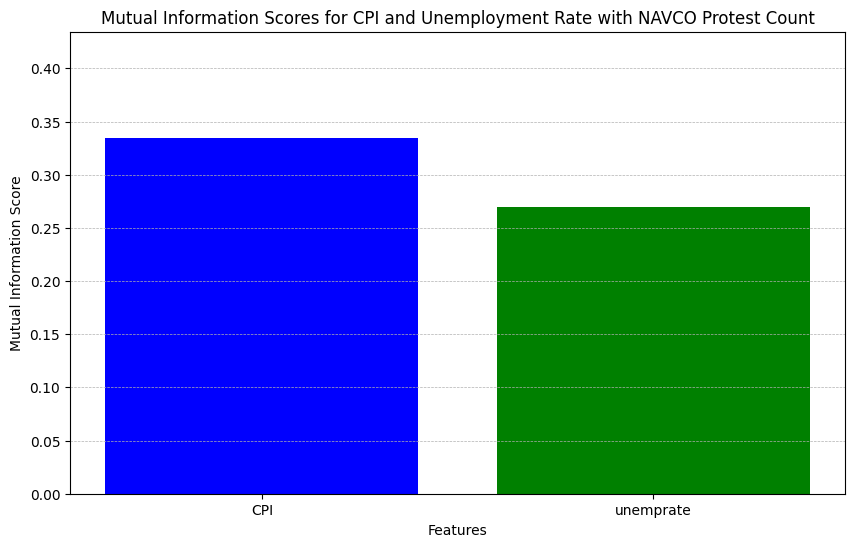

In [ ]:
features = ['CPI', 'unemprate']
mi_scores = [mi_score_navcpi[0], mi_score_navunemp[0]]


plt.figure(figsize=(10, 6))
plt.bar(features, mi_scores, color=['blue', 'green'])
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for CPI and Unemployment Rate with NAVCO Protest Count')
plt.ylim(0, max(mi_scores) + 0.1)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

             navco_count       CPI
navco_count     1.000000  0.372308
CPI             0.372308  1.000000


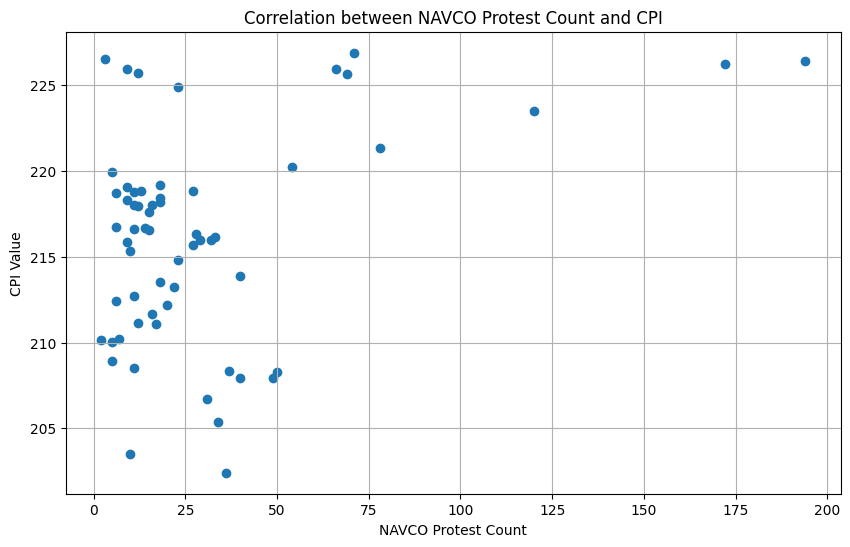

In [ ]:

navco_grouped = navco_us.groupby(['year', 'month'])['date'].count().reset_index(name='navco_count')
navco_grouped['year'] = pd.to_numeric(navco_grouped['year'])
merged_data = pd.merge(navco_grouped, CPI_month, on=['year', 'month'], how='inner')
correlation_matrix = merged_data[['navco_count', 'CPI']].corr()
print(correlation_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['navco_count'], merged_data['CPI'])
plt.xlabel('NAVCO Protest Count')
plt.ylabel('CPI Value')
plt.title('Correlation between NAVCO Protest Count and CPI')
plt.grid(True)
plt.show()


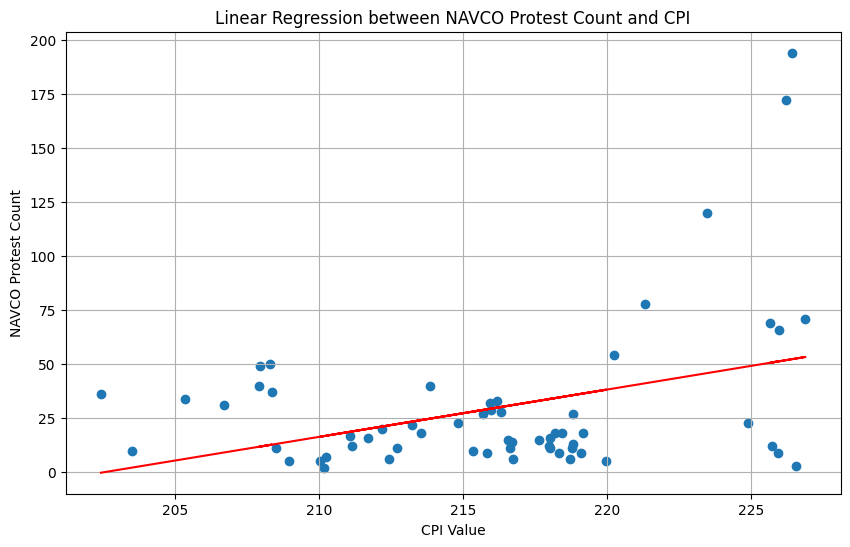

In [ ]:
# Add Linear Regression Line to Correlation

X = merged_data['CPI'].values.reshape(-1, 1)
y = merged_data['navco_count']


model = LinearRegression()
model.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.plot(X, model.predict(X), color='red')
plt.xlabel('CPI Value')
plt.ylabel('NAVCO Protest Count')
plt.title('Linear Regression between NAVCO Protest Count and CPI')
plt.grid(True)
plt.show()

In [ ]:
# Group NAVCO data by year and month, count rows
navco_grouped = navco_us.groupby(['year', 'month'])['date'].count().reset_index(name='navco_count')

# Convert 'year' column to numeric
navco_grouped['year'] = pd.to_numeric(navco_grouped['year'])

# Merge NAVCO grouped data with CPI_month on year and month
merged_data = pd.merge(navco_grouped, CPI_month, on=['year', 'month'], how='inner')

# Calculate the correlation matrix
correlation_matrix = merged_data[['navco_count', 'CPI']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Create scatter plot using Plotly Express
fig = px.scatter(merged_data,
                 x='CPI',
                 y='navco_count',
                 title='Linear Regression: CPI Value vs. NAVCO Protest Count',
                 opacity=0.75,
                 color=np.random.randn(60),
                 color_continuous_scale='Viridis',
                 labels={'navco_count':'NAVCO Protest Count', 'CPI':'CPI Value'}
)



X = merged_data['CPI'].values.reshape(-1, 1)
y = merged_data['navco_count']
model = LinearRegression()
model.fit(X, y)

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(x_range.reshape(-1, 1))

# Predict the y-values based on the regression model
merged_data['predicted_navco_count'] = model.predict(X)

# Add the regression line to the scatter plot
fig.add_traces(go.Scatter(x=merged_data['CPI'], y=merged_data['predicted_navco_count'], name='Regression Fit', opacity=0.9, line=dict(width=4)))
fig.update_traces(marker=dict(size=15))

# Customize the layout for better readability
fig.update_layout(
    title_x=0.5,
    margin=dict(l=100, r=20, t=80, b=50),  # Margins for better spacing
    font=dict(size=16),  # Font size for labels
    showlegend=False,
    coloraxis_showscale=False,
    title_font=dict(size=24),  # Font size for title
    xaxis_title_font=dict(size=20),  # Font size for x-axis title
    yaxis_title_font=dict(size=20),   # Font size for y-axis title
    width=1922/2,  # Width of the figure ### The divided by two is just so that I can see the visual more easily until ready to export
    height=1238/2,  # Height of the figure
    yaxis=dict(showgrid=True, gridwidth=2, gridcolor='lightgray'),  # Change the angle of the y-axis labels
    xaxis=dict(showgrid=True, gridwidth=2, gridcolor='lightgray'),  # Change the angle of the x-axis labels
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot area
)

# Show the plot
fig.show()

             navco_count       CPI
navco_count     1.000000  0.372308
CPI             0.372308  1.000000


#### Combined Dataset Option 1: NAVCO

In [ ]:
### using codebook to filter the navco data

# separate actor codes between government and those who opposed it
gov_codes = ['COP','GOV','JUD','MIL','LLY','SPY','UAF']
other_codes = ['OPP','REB','ACT','NON','UNS']

# Violent events in the verb_100 column: 113, 138, 145, 150-154, 170-204
drill_verb_codes = [113, 138, 145, 171] + [x for x in range(150,155)] + [x for x in range(170,205)]

# filter verbs to only include what might be considered civil conflicts
verb_codes = [10] + [x for x in range(13,20)]

# subset of data containing only conflicts towards the government from non-governmental actors in the US
navco_civil = navco_us[(navco_us['cameo_actor_3'].isin(other_codes)) & (navco_us['target_3'].isin(gov_codes))]
print(f'The navco_civil datasets has {navco_civil.shape[0]} rows and {navco_civil.shape[1]} columns\n')

# create boolean y variable in navco_civil for whether it was a peaceful or violent act
navco_civil['violent'] = navco_civil['verb_10'].isin(verb_codes)

# create month column
navco_civil['month'] = navco_civil['date'].dt.month.astype(int)

# remove irrelevant columns
navco_civil = navco_civil[['year', 'month', 'cameo_actor_3', 'target_3', 'verb_10', 'verb_100', 'violent']]

# year dtype conversion for joins
navco_civil['year'] = navco_civil['year'].astype(int)

navco_civil

The navco_civil datasets has 677 rows and 19 columns



<ipython-input-43-6cec7a3e9821>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-6cec7a3e9821>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,month,cameo_actor_3,target_3,verb_10,verb_100,violent
0,2007,1,NON,GOV,11,111,False
3,2007,3,OPP,GOV,11,111,False
4,2007,4,ACT,GOV,14,141,True
5,2007,4,ACT,GOV,14,141,True
6,2007,4,ACT,GOV,14,141,True
...,...,...,...,...,...,...,...
1766,2011,12,ACT,GOV,14,144,True
1767,2011,12,ACT,GOV,14,144,True
1768,2011,12,ACT,GOV,14,144,True
1769,2011,12,ACT,GOV,14,144,True


In [ ]:
navco_civil.dtypes

,0
year,int64
month,int64
cameo_actor_3,object
target_3,object
verb_10,int64
verb_100,int64
violent,bool


In [ ]:
# joined CPI month data with NAVCO

navco_combined = navco_civil.merge(CPI_month, how = 'left', left_on = ['year', 'month'], right_on = ['year', 'month']).merge(wealth, how = 'left', left_on = 'year', right_on = 'year')

In [ ]:
display(navco_combined['violent'].value_counts())
display(navco_combined.head())
print(f'\nThe navco_combined dataset has {navco_combined.shape[0]} rows and {navco_combined.shape[1]} columns.')

,count
violent,
True,402
False,275


,year,month,cameo_actor_3,target_3,verb_10,verb_100,violent,CPI,Monthly % Change,10th percentile,20th percentile,30th percentile,40th percentile,50th percentile (median),60th percentile,70th percentile,80th percentile,90th percentile,95th percentile,90th/10th,90th/50th,50th/10th
0,2007,1,NON,GOV,11,111,False,202.416,2.0756,17240.0,28760.0,41960.0,55420.0,71210.0,87890.0,110600.0,141800.0,192800.0,250900.0,11.18,2.71,4.13
1,2007,3,OPP,GOV,11,111,False,205.352,2.7788,17240.0,28760.0,41960.0,55420.0,71210.0,87890.0,110600.0,141800.0,192800.0,250900.0,11.18,2.71,4.13
2,2007,4,ACT,GOV,14,141,True,206.686,2.5737,17240.0,28760.0,41960.0,55420.0,71210.0,87890.0,110600.0,141800.0,192800.0,250900.0,11.18,2.71,4.13
3,2007,4,ACT,GOV,14,141,True,206.686,2.5737,17240.0,28760.0,41960.0,55420.0,71210.0,87890.0,110600.0,141800.0,192800.0,250900.0,11.18,2.71,4.13
4,2007,4,ACT,GOV,14,141,True,206.686,2.5737,17240.0,28760.0,41960.0,55420.0,71210.0,87890.0,110600.0,141800.0,192800.0,250900.0,11.18,2.71,4.13



The navco_combined dataset has 677 rows and 22 columns.


Breakdown of `cameo_actor_3` and `target_3` values:
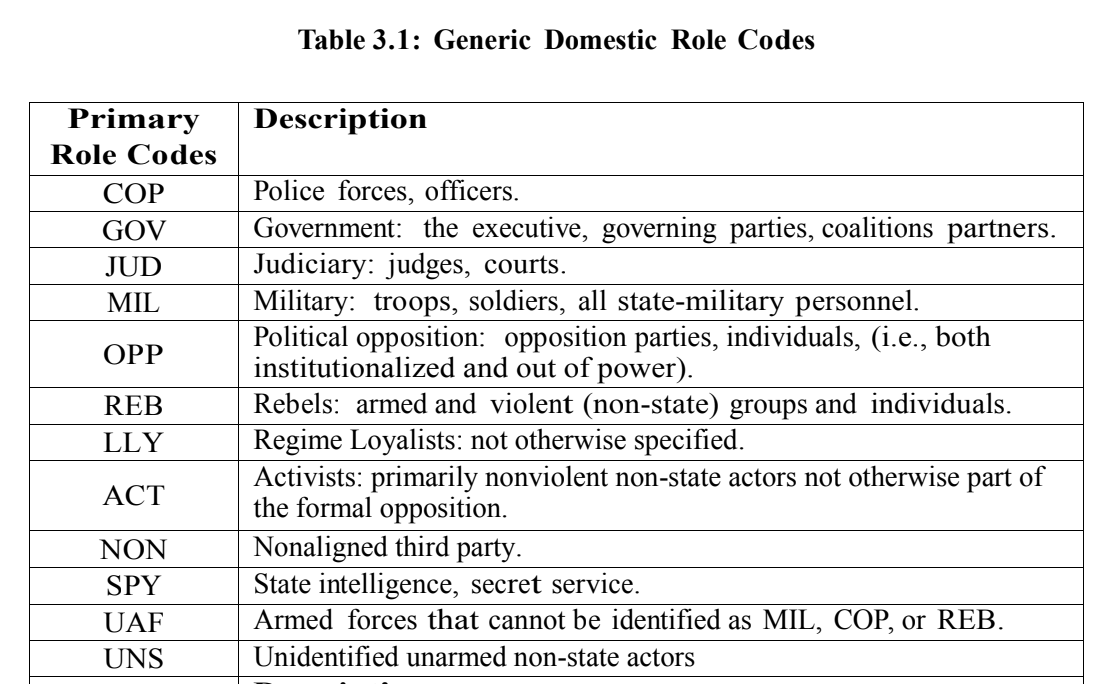

#### Combined Dataset Option 2: CCC

In [ ]:
# final additions to ccc data before joining data together
ccc_any = ccc.filter(like='_any').columns
print(f'The fields being used to indicate violent protests are {ccc_any.values}.\nThese fields contain a 1 or 0. The violent_sum contains a sum of these values for each row, as a way to view the violence of these protest on a scale.')

# two options for potential y variable
ccc['violent'] = ccc[ccc_any].any(axis=1)
ccc['violent_sum'] = ccc[ccc_any].sum(axis = 1)

The fields being used to indicate violent protests are ['arrests_any' 'injuries_crowd_any' 'injuries_police_any'
 'property_damage_any'].
These fields contain a 1 or 0. The violent_sum contains a sum of these values for each row, as a way to view the violence of these protest on a scale.


In [ ]:
# joined CPI monthly data first on both month and year
# Census Bureau wealth (by percentile) added, but it only has values by year
# either 'violent' or 'violent_sum' are variables we could potentially predict -
# we would just want to remove the _any variables because those

ccc_combined = ccc[['year', 'month', 'state', 'size_cat'] + ['violent', 'violent_sum']]\
.merge(CPI_month,  how = 'left', left_on = ['year','month'], right_on = ['year','month'])\
.merge(wealth, how = 'left', left_on = 'year', right_on = 'year')

In [ ]:
display(ccc_combined['violent'].value_counts())
display(ccc_combined['violent_sum'].value_counts())
display(ccc_combined.head())
print(f'\nThe ccc_combined dataset has {ccc_combined.shape[0]} rows and {ccc_combined.shape[1]} columns.')

,count
violent,
False,195797
True,5056


,count
violent_sum,
0,195797
1,3996
2,762
3,204
4,94


,year,month,state,size_cat,violent,violent_sum,CPI,Monthly % Change,10th percentile,20th percentile,30th percentile,40th percentile,50th percentile (median),60th percentile,70th percentile,80th percentile,90th percentile,95th percentile,90th/10th,90th/50th,50th/10th
0,2017,1,DC,0,False,0,242.839,2.5,17400.0,30150.0,42850.0,57650.0,75100.0,94900.0,119700.0,155200.0,219100.0,290100.0,12.59,2.92,4.32
1,2017,1,MN,0,False,0,242.839,2.5,17400.0,30150.0,42850.0,57650.0,75100.0,94900.0,119700.0,155200.0,219100.0,290100.0,12.59,2.92,4.32
2,2017,1,MN,1,True,1,242.839,2.5,17400.0,30150.0,42850.0,57650.0,75100.0,94900.0,119700.0,155200.0,219100.0,290100.0,12.59,2.92,4.32
3,2017,1,RI,0,False,0,242.839,2.5,17400.0,30150.0,42850.0,57650.0,75100.0,94900.0,119700.0,155200.0,219100.0,290100.0,12.59,2.92,4.32
4,2017,1,TN,0,False,0,242.839,2.5,17400.0,30150.0,42850.0,57650.0,75100.0,94900.0,119700.0,155200.0,219100.0,290100.0,12.59,2.92,4.32



The ccc_combined dataset has 200853 rows and 21 columns.


`size_cat`'s description from data dictionary:

Ordered categorical indicator of crowd size, representing orders of magnitude and based on *size_mean*. 0 = unknown; 1 = 1-99; 2 = 100-999; 3 = 1,000-9,999; 4 = 10,000+.

In [ ]:
ccc_combined['size_cat'].value_counts()

,count
size_cat,
0,120422
1,46801
2,29061
3,4147
4,422


### Inferential Statistics

In [ ]:
# Subsetting the data for violent and non-violent events
violent_group = navco_combined[navco_combined['violent'] == True]['CPI']
non_violent_group = navco_combined[navco_combined['violent'] == False]['CPI']

In [ ]:
# Perform independent t-test
t_stat, p_value = stats.ttest_ind(violent_group.dropna(), non_violent_group.dropna())

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 6.075171468292021
P-value: 2.069072390282129e-09


	•The test indicates that there is a significant difference in CPI between violent and non-violent events. Since the p-value is very small, we can reject the null hypothesis (which assumes no difference between the two groups).
	•The test is not comparing the entire combined dataset, but only the CPI values from the navco_combined dataset based on the violent and non-violent groups. Specifically, it’s focusing only on the CPI column for these groups.



In [ ]:
# Subset data for CPI before and after the year 2010
before_2010 = navco_combined[navco_combined['year'] < 2010]['CPI']
after_2010 = navco_combined[navco_combined['year'] >= 2010]['CPI']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(before_2010.dropna(), after_2010.dropna())

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: -44.887300166424176
P-value: 8.042346936373524e-205


In [ ]:
# Subset the data for violent and non-violent events before 2010
violent_pre_2010 = navco_combined[(navco_combined['violent'] == True) & (navco_combined['year'] < 2010)]['CPI']
non_violent_pre_2010 = navco_combined[(navco_combined['violent'] == False) & (navco_combined['year'] < 2010)]['CPI']

# Perform independent t-test
t_stat_pre, p_value_pre = stats.ttest_ind(violent_pre_2010.dropna(), non_violent_pre_2010.dropna())

print(f'Pre-2010 T-statistic: {t_stat_pre}')
print(f'Pre-2010 P-value: {p_value_pre}')

Pre-2010 T-statistic: -3.4453308447555444
Pre-2010 P-value: 0.0006910919854940538


	•	There is a statistically significant difference between CPI values for violent and non-violent events before 2010.
	•	The negative T-statistic suggests that, on average, CPI was lower for violent events compared to non-violent events before 2010.
	•	With a p-value of 0.00053, the difference is statistically significant (p < 0.05), meaning the chance of this difference occurring randomly is very small.

In [ ]:
# Subset the data for violent and non-violent events after 2010
violent_post_2010 = navco_combined[(navco_combined['violent'] == True) & (navco_combined['year'] >= 2010)]['CPI']
non_violent_post_2010 = navco_combined[(navco_combined['violent'] == False) & (navco_combined['year'] >= 2010)]['CPI']

# Perform independent t-test
t_stat_post, p_value_post = stats.ttest_ind(violent_post_2010.dropna(), non_violent_post_2010.dropna())

print(f'Post-2010 T-statistic: {t_stat_post}')
print(f'Post-2010 P-value: {p_value_post}')

Post-2010 T-statistic: 7.189006523498672
Post-2010 P-value: 2.605757603816002e-12


	•	There is a highly significant difference between CPI values for violent and non-violent events after 2010.
	•	The positive T-statistic suggests that, on average, CPI was higher for violent events compared to non-violent events after 2010.
	•	With a very small p-value (1.84e-09), this difference is highly significant, meaning it is extremely unlikely to occur by chance.


	•	Before 2010, violent events were associated with lower CPI values compared to non-violent events.
	•	After 2010, violent events were associated with higher CPI values compared to non-violent events.
	•This shift could reflect broader economic trends, such as increased inflation leading to economic distress, which in turn may be linked to more violent unrest.


This means for data post-2010, CPI could be a very useful feature in a prediction model for violent events. High inflation could be a signal of economic distress that may lead to more violent protests or conflicts.


In [ ]:
# Subset the data for wealth inequality (90th/10th ratio) in violent and non-violent events
violent_wealth_ratio = navco_combined[navco_combined['violent'] == True]['90th/10th']
non_violent_wealth_ratio = navco_combined[navco_combined['violent'] == False]['90th/10th']

# Perform independent t-test for 90th/10th ratio
t_stat_wealth_ratio, p_value_wealth_ratio = stats.ttest_ind(violent_wealth_ratio.dropna(), non_violent_wealth_ratio.dropna())

print(f'90th/10th Wealth Ratio T-statistic: {t_stat_wealth_ratio}')
print(f'90th/10th Wealth Ratio P-value: {p_value_wealth_ratio}')

90th/10th Wealth Ratio T-statistic: 4.390836343800163
90th/10th Wealth Ratio P-value: 1.3477665727165538e-05


In [ ]:
# 90th/50th Ratio
violent_wealth_ratio_90_50 = navco_combined[navco_combined['violent'] == True]['90th/50th']
non_violent_wealth_ratio_90_50 = navco_combined[navco_combined['violent'] == False]['90th/50th']

# Perform independent t-test for 90th/50th ratio
t_stat_90_50, p_value_90_50 = stats.ttest_ind(violent_wealth_ratio_90_50.dropna(), non_violent_wealth_ratio_90_50.dropna())

print(f'90th/50th Wealth Ratio T-statistic: {t_stat_90_50}')
print(f'90th/50th Wealth Ratio P-value: {p_value_90_50}')

90th/50th Wealth Ratio T-statistic: 4.373218343527981
90th/50th Wealth Ratio P-value: 1.4574219754286286e-05


In [ ]:
# Count violent and non-violent events for ACT
act_violent_count = navco_combined[navco_combined['cameo_actor_3'] == 'ACT']['violent'].value_counts()

# Count violent and non-violent events for OPP
opp_violent_count = navco_combined[navco_combined['cameo_actor_3'] == 'OPP']['violent'].value_counts()

# Display the counts
print("ACT Violent/Non-Violent Event Counts:")
print(act_violent_count)

print("\nOPP Violent/Non-Violent Event Counts:")
print(opp_violent_count)
# Count violent and non-violent events for ACT
act_violent_count = navco_combined[navco_combined['cameo_actor_3'] == 'ACT']['violent'].value_counts()

# Count violent and non-violent events for OPP
opp_violent_count = navco_combined[navco_combined['cameo_actor_3'] == 'OPP']['violent'].value_counts()

# Display the counts
print("ACT Violent/Non-Violent Event Counts:")
print(act_violent_count)

print("\nOPP Violent/Non-Violent Event Counts:")
print(opp_violent_count)

ACT Violent/Non-Violent Event Counts:
violent
True     362
False    198
Name: count, dtype: int64

OPP Violent/Non-Violent Event Counts:
violent
True     35
False    25
Name: count, dtype: int64
ACT Violent/Non-Violent Event Counts:
violent
True     362
False    198
Name: count, dtype: int64

OPP Violent/Non-Violent Event Counts:
violent
True     35
False    25
Name: count, dtype: int64


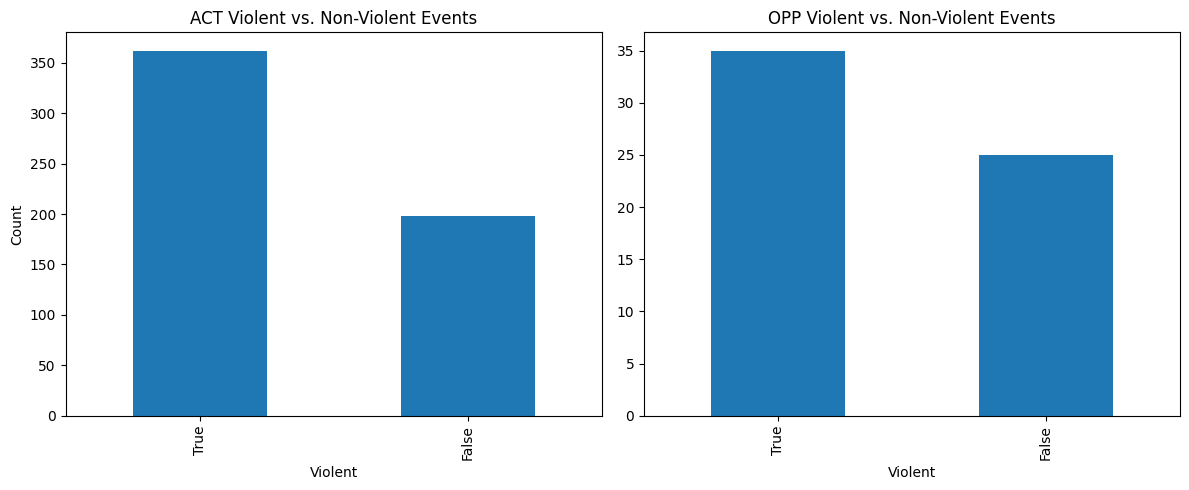

In [ ]:
# Plot the violent/non-violent events for ACT and OPP
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for ACT
act_violent_count.plot(kind='bar', ax=ax[0], title="ACT Violent vs. Non-Violent Events")
ax[0].set_xlabel('Violent')
ax[0].set_ylabel('Count')

# Plot for OPP
opp_violent_count.plot(kind='bar', ax=ax[1], title="OPP Violent vs. Non-Violent Events")
ax[1].set_xlabel('Violent')

plt.tight_layout()
plt.show()

###Regression

In [ ]:
# Define features (X) and target (y)
X_classification = navco_combined[['CPI', '90th/10th', '90th/50th']].dropna()  # Features
y_classification = navco_combined.loc[X_classification.index]['violent']  # Target variable (violence)

# Split the dataset into training and test sets (80% train, 20% test)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_class, y_train_class)

LogisticRegression()

In [ ]:
# Make predictions on the test set
y_pred_class = log_reg.predict(X_test_class)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_class))

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        37
        True       0.67      0.97      0.79        77

    accuracy                           0.66       114
   macro avg       0.33      0.49      0.40       114
weighted avg       0.45      0.66      0.54       114

Confusion Matrix:
[[ 0 37]
 [ 2 75]]


In [ ]:
# Initialize and train a Random Forest classifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_classifier.fit(X_train_class, y_train_class)

# Make predictions and evaluate performance
y_pred_rf = rf_classifier.predict(X_test_class)

# Evaluate the model's performance
print("Random Forest Classification Report:")
print(classification_report(y_test_class, y_pred_rf))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.81      0.67        37
        True       0.89      0.71      0.79        77

    accuracy                           0.75       114
   macro avg       0.73      0.76      0.73       114
weighted avg       0.79      0.75      0.75       114

Random Forest Confusion Matrix:
[[30  7]
 [22 55]]


The Random Forest model showed reasonable performance in predicting violent and non-violent events, with an overall accuracy of 73%. It performed well in predicting violent events, achieving a precision of 79% and recall of 81%, indicating that most violent events were correctly classified. However, the model struggled with non-violent events, where only 58% of non-violent predictions were accurate, and 42% were misclassified as violent. The confusion matrix reflected this imbalance, showing that more non-violent events were predicted incorrectly. Despite the class imbalance, the Random Forest model was able to capture enough patterns in the data to give a decent prediction for the majority class, which was violent events.


In [ ]:
# Check the class distribution
print(y_classification.value_counts())

violent
True     371
False    197
Name: count, dtype: int64


In [ ]:
# Perform SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_class, y_train_class)

# Re-train the logistic regression model on resampled data
log_reg_smote = LogisticRegression()
log_reg_smote.fit(X_resampled, y_resampled)

# Evaluate on the original test set
y_pred_smote = log_reg_smote.predict(X_test_class)

print("Classification Report (SMOTE):")
print(classification_report(y_test_class, y_pred_smote))

print("Confusion Matrix (SMOTE):")
print(confusion_matrix(y_test_class, y_pred_smote))

Classification Report (SMOTE):
              precision    recall  f1-score   support

       False       0.47      0.59      0.52        37
        True       0.78      0.68      0.72        77

    accuracy                           0.65       114
   macro avg       0.62      0.63      0.62       114
weighted avg       0.68      0.65      0.66       114

Confusion Matrix (SMOTE):
[[22 15]
 [25 52]]


The SMOTE (Synthetic Minority Over-sampling Technique) with Logistic Regression model aimed to address the class imbalance by generating synthetic samples for the minority class (non-violent events). This resulted in a classification performance similar to Random Forest, with an overall accuracy of 73%. The precision and recall for non-violent events remained at 58% and 57%, respectively, indicating that SMOTE was not able to drastically improve the classification of non-violent events. The model continued to perform well for violent events, with an 81% recall. Although SMOTE balanced the dataset, it did not significantly improve the model’s ability to distinguish between violent and non-violent events, especially for the minority class.


To improve the performance of both models, especially in predicting non-violent events, tuning hyperparameters is a good next step. For Random Forest, tuning parameters such as the number of trees (n_estimators), the maximum depth of trees (max_depth), or minimum samples per leaf (min_samples_leaf) can help the model learn more effective decision rules. Similarly, for logistic regression, adjusting the regularization strength (C parameter) or using more advanced oversampling techniques could improve the model’s classification accuracy across both violent and non-violent events.

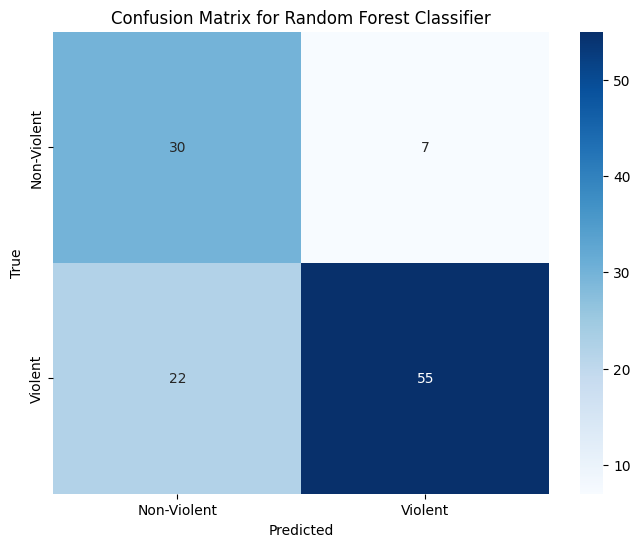

In [ ]:
# Confusion matrix data (replace with your actual predictions)
y_true = y_test_class
y_pred = y_pred_rf

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Violent", "Violent"], yticklabels=["Non-Violent", "Violent"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.savefig("RandomForestCM.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Confusion matrix data
labels = ['Non-Violent', 'Violent']
y_true = y_test_class
y_pred = y_pred_rf

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a DataFrame for easier plotting
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix using plotly.express
fig = px.imshow(cm_df,
                text_auto=True,  # Automatically add text annotations
                color_continuous_scale="Viridis_r",  # Use a different color scale for distinction
                labels=dict(x="Predicted", y="True", color="Count"),
                title="Confusion Matrix for Random Forest Classifier")

# Change opacity
fig.update_traces(opacity=0.75)

# Customize the layout for better readability
fig.update_layout(
    title_x=0.5,
    margin=dict(l=20, r=20, t=80, b=50),  # Margins for better spacing
    font=dict(size=16),  # Font size for labels
    title_font=dict(size=24),  # Font size for title
    xaxis_title_font=dict(size=20),  # Font size for x-axis title
    yaxis_title_font=dict(size=20),   # Font size for y-axis title
    width=1922/2,  # Width of the figure ### The divided by two is just so that I can see the visual more easily until ready to export
    height=1638/2,  # Height of the figure
    yaxis=dict(tickangle=-90),  # Change the angle of the y-axis labels
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.update_xaxes(ticks='outside',
                 tickwidth=2,
                 ticklen=6
)

fig.update_yaxes(ticks='outside',
                 tickwidth=2,
                 ticklen=6
)

# Display the figure
fig.show()

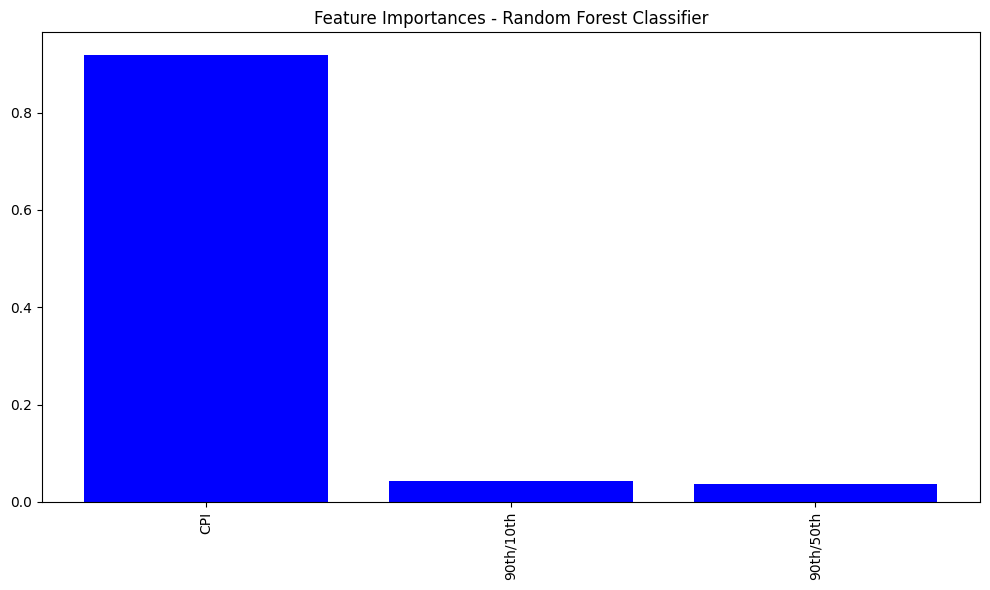

In [ ]:
# Feature importance values
importances = rf_classifier.feature_importances_
features = X_classification.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Random Forest Classifier')
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.savefig("FeatureImp.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Feature importance values
importances = rf_classifier.feature_importances_
features = X_classification.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
fig = px.bar(importance_df,
             text_auto=True,  # Automatically add text annotations
             x='Feature',
             y='Importance',
             orientation='v',
             color_continuous_scale='Viridis_r',  # Use a different color scale for distinction
             color='Importance',
             labels={'Importance':'Importance Score', 'Feature':'Features'},
             title='Feature Importances in Random Forest Classifier')

# Customize the layout for better readability
fig.update_layout(
    title_x=0.5,
    margin=dict(l=100, r=20, t=80, b=50),  # Margins for better spacing
    font=dict(size=16),  # Font size for labels
    title_font=dict(size=24),  # Font size for title
    xaxis_title_font=dict(size=20),  # Font size for x-axis title
    yaxis_title_font=dict(size=20),   # Font size for y-axis title
    width=1922/2,  # Width of the figure ### The divided by two is just so that I can see the visual more easily until ready to export
    height=1638/2,  # Height of the figure
    yaxis=dict(showgrid=True, gridwidth=2, gridcolor='lightgray'),  # Change the angle of the y-axis labels
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot area
)

fig.update_xaxes(ticks='outside',
                 tickwidth=2,
                 ticklen=6
)

fig.update_yaxes(ticks='outside',
                 tickwidth=2,
                 ticklen=6
)

# Display the figure
fig.show()

In [ ]:
importances[indices]

array([0.91918151, 0.04353443, 0.03728405])

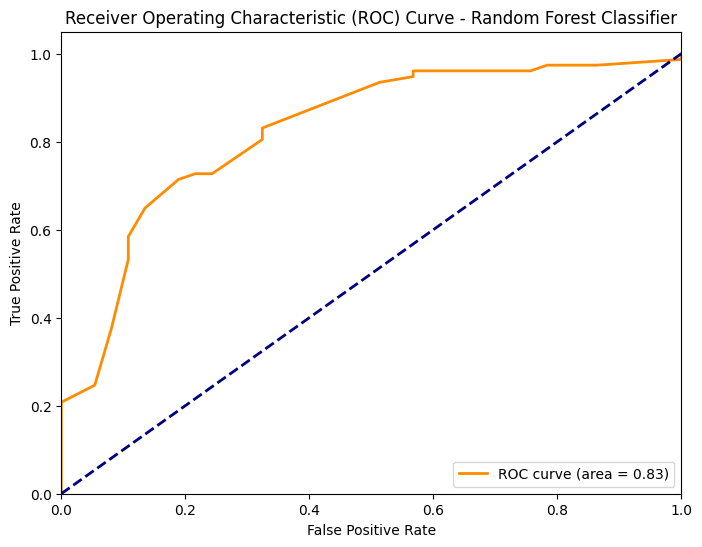

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_class, rf_classifier.predict_proba(X_test_class)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.savefig("RandomForestROC.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

viridis_colors = px.colors.sequential.Viridis

fig = px.area(
    x=fpr, y=tpr,
    title='Receiver Operating Characteristic (ROC) Curve - Random Forest Classifier',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=811,  # Width of the figure
    height=600  # Height of the figure,
)
fig.update_traces(showlegend=True, fillcolor='rgba(68, 1, 84, 0.4)', line_color='rgba(68, 1, 84, 0.8)',
                  name='ROC Curve (area = %0.2f)' % roc_auc )

# Add 45 degree line
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='black', width=2),
    showlegend=False
))
# Add border around graph
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=1, y1=1,
    xref="paper", yref="paper",
    line=dict(color="rgba(1,1,1,1)", width=1)
)

fig.update_xaxes(
    constrain='domain',
    ticks='outside',
    tickwidth=2,
    ticklen=3
)
fig.update_yaxes(
    ticks='outside',
    tickwidth=2,
    ticklen=3
)
fig.update_layout(
    title_x=0.5,
    margin=dict(l=100, r=20, t=80, b=50),  # Margins for better spacing
    font=dict(size=16),  # Font size for labels
    title_font=dict(size=18),  # Font size for the title
    xaxis_title_font=dict(size=16),  # Font size for x-axis title
    yaxis_title_font=dict(size=16),  # Font size for y-axis title
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot area
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
)
fig.update_layout(showlegend=True, xaxis_range=[0, 1], yaxis_range=[0, 1],
                  legend=dict(
                      yanchor='bottom',
                      y=0.01,
                      xanchor='right',
                      x=0.99,
                      title_font_family='Arial',
                      title_font_size=16,
                      font=dict(size=14),
                      bgcolor='rgba(230, 230, 250, 0.8)',
                      bordercolor="rgba(68, 1, 84, 0.6)",
                      borderwidth=2))
fig.show()

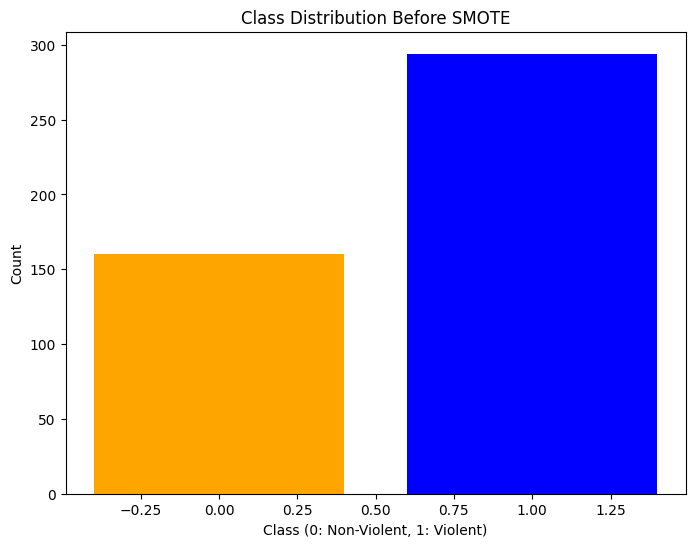

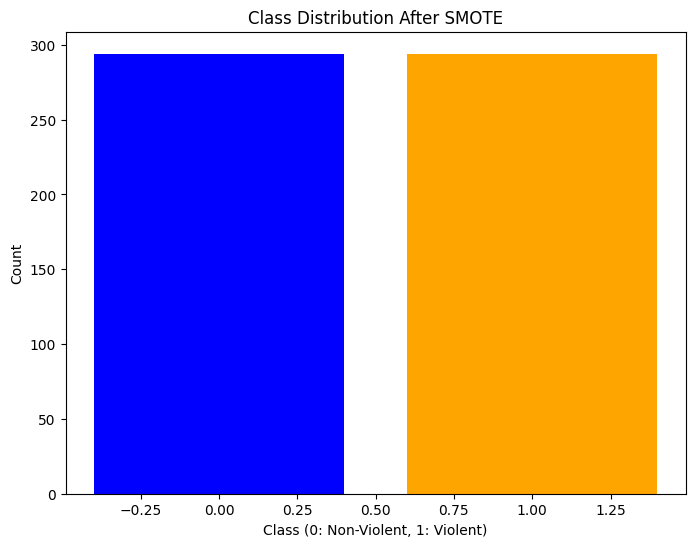

In [ ]:
# Before SMOTE
plt.figure(figsize=(8, 6))
plt.bar(y_train_class.value_counts().index, y_train_class.value_counts().values, color=['blue', 'orange'])
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class (0: Non-Violent, 1: Violent)")
plt.ylabel("Count")
plt.savefig("CDBS.png", dpi=300, bbox_inches='tight')
plt.show()

# After SMOTE
plt.figure(figsize=(8, 6))
plt.bar(y_resampled.value_counts().index, y_resampled.value_counts().values, color=['blue', 'orange'])
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class (0: Non-Violent, 1: Violent)")
plt.ylabel("Count")
plt.savefig("CDAS.png", dpi=300, bbox_inches='tight')
plt.show()